In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import gzip
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

project_dir = Path().resolve().parent.parent

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Load and preprocess the FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class MNISTDataset(Dataset):
    def __init__(self,datadir,transform,is_train = True):
        super().__init__()
        self.datadir = datadir
        self.img,self.label = self.load_data(self.datadir, is_train = is_train)
        self.len_data = len(self.img)
        self.transform = transform
        
    def __getitem__(self,index):
        return self.transform(self.img[index]), self.label[index]
    
    def __len__(self):
        return self.len_data
    
    def load_data(self, datadir, is_train):
        dirname = os.path.join(datadir)
        files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
            't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']

        paths = []
        for fname in files:
            paths.append(os.path.join(dirname,fname))
        if is_train:
            with gzip.open(paths[0], 'rb') as lbpath:
                label = np.frombuffer(lbpath.read(), np.uint8, offset=8)
            with gzip.open(paths[1], 'rb') as imgpath:
                img = np.frombuffer(imgpath.read(), np.uint8,
                                   offset=16).reshape(len(label), 28, 28)
        else:
            with gzip.open(paths[2], 'rb') as lbpath:
                label = np.frombuffer(lbpath.read(), np.uint8, offset=8)
            with gzip.open(paths[3], 'rb') as imgpath:
                img = np.frombuffer(imgpath.read(), np.uint8,
                                      offset=16).reshape(len(label), 28, 28)
        return img, label

# Load the datasets with the provided code
train_dataset = MNISTDataset(
    datadir=os.path.join(project_dir, 'data/FashionMNIST/raw'),
    transform=transform,
    is_train=True
)
test_dataset = MNISTDataset(
    datadir=os.path.join(project_dir, 'data/FashionMNIST/raw'),
    transform=transform,
    is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Data shape: torch.Size([1, 28, 28])
Label: Ankle boot


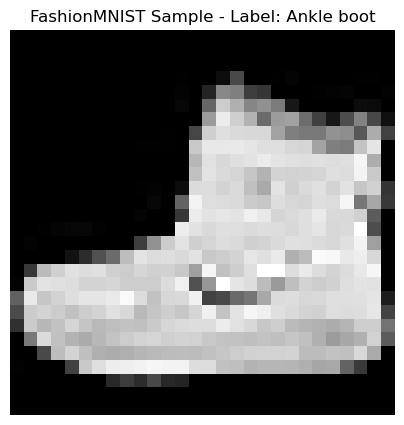

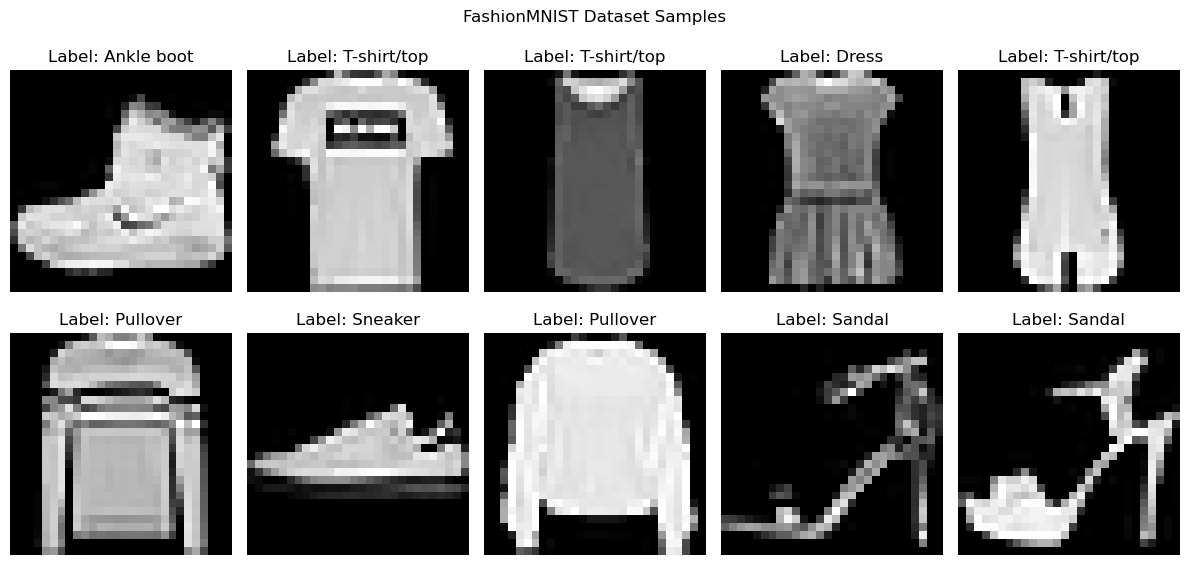

Dataset sizes:
Training set: 60000 samples
Test set: 10000 samples


In [12]:
# Define label descriptions
label_descriptions = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Get a sample and display it
data, target = train_dataset[0]
print(f"Data shape: {data.shape}")
print(f"Label: {label_descriptions[target]}")

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(data.squeeze(), cmap='gray')
plt.title(f"FashionMNIST Sample - Label: {label_descriptions[target]}")
plt.axis('off')
plt.show()

# Display multiple samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("FashionMNIST Dataset Samples")

for i, ax in enumerate(axes.flat):
    data, target = train_dataset[i]
    ax.imshow(data.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label_descriptions[target]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Dataset sizes:")
print(f"Training set: {len(train_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")


In [7]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Initialize the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.4291
Epoch [2/10], Loss: 0.2743
Epoch [3/10], Loss: 0.2272
Epoch [4/10], Loss: 0.1946
Epoch [5/10], Loss: 0.1709
Epoch [6/10], Loss: 0.1483
Epoch [7/10], Loss: 0.1272
Epoch [8/10], Loss: 0.1106
Epoch [9/10], Loss: 0.0906
Epoch [10/10], Loss: 0.0792
Accuracy on test set: 91.88%
